Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Reading the data

In [2]:
df = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

EDA (Exploratory Data Analysis) + Data Preprocessing

In [3]:
df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [6]:
df.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [7]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=False)

In [8]:
def scale_columns(df, columns_to_scale):
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(df[columns_to_scale])

    for i, col in enumerate(columns_to_scale):
        df[col + '_scaled'] = scaled_features[:, i]

    return df


In [9]:
cols =['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
df = scale_columns(df, cols)

In [10]:
cols += ['id']
df.drop(cols, axis=1, inplace=True)


In [11]:
df.head(5)

,Calories,Sex_female,Sex_male,Age_scaled,Height_scaled,Weight_scaled,Duration_scaled,Heart_Rate_scaled,Body_Temp_scaled
0,150.0,False,True,-0.166667,0.714286,0.333333,0.733333,0.400000,0.636364
1,34.0,True,False,1.000000,-0.523810,-0.583333,-0.466667,-0.666667,-0.545455
2,29.0,True,False,0.458333,-0.619048,-0.416667,-0.533333,-0.733333,-0.454545
3,140.0,False,True,-0.833333,0.857143,0.666667,0.666667,0.666667,0.363636
4,146.0,True,False,-0.083333,-0.380952,-0.541667,0.666667,0.466667,0.272727


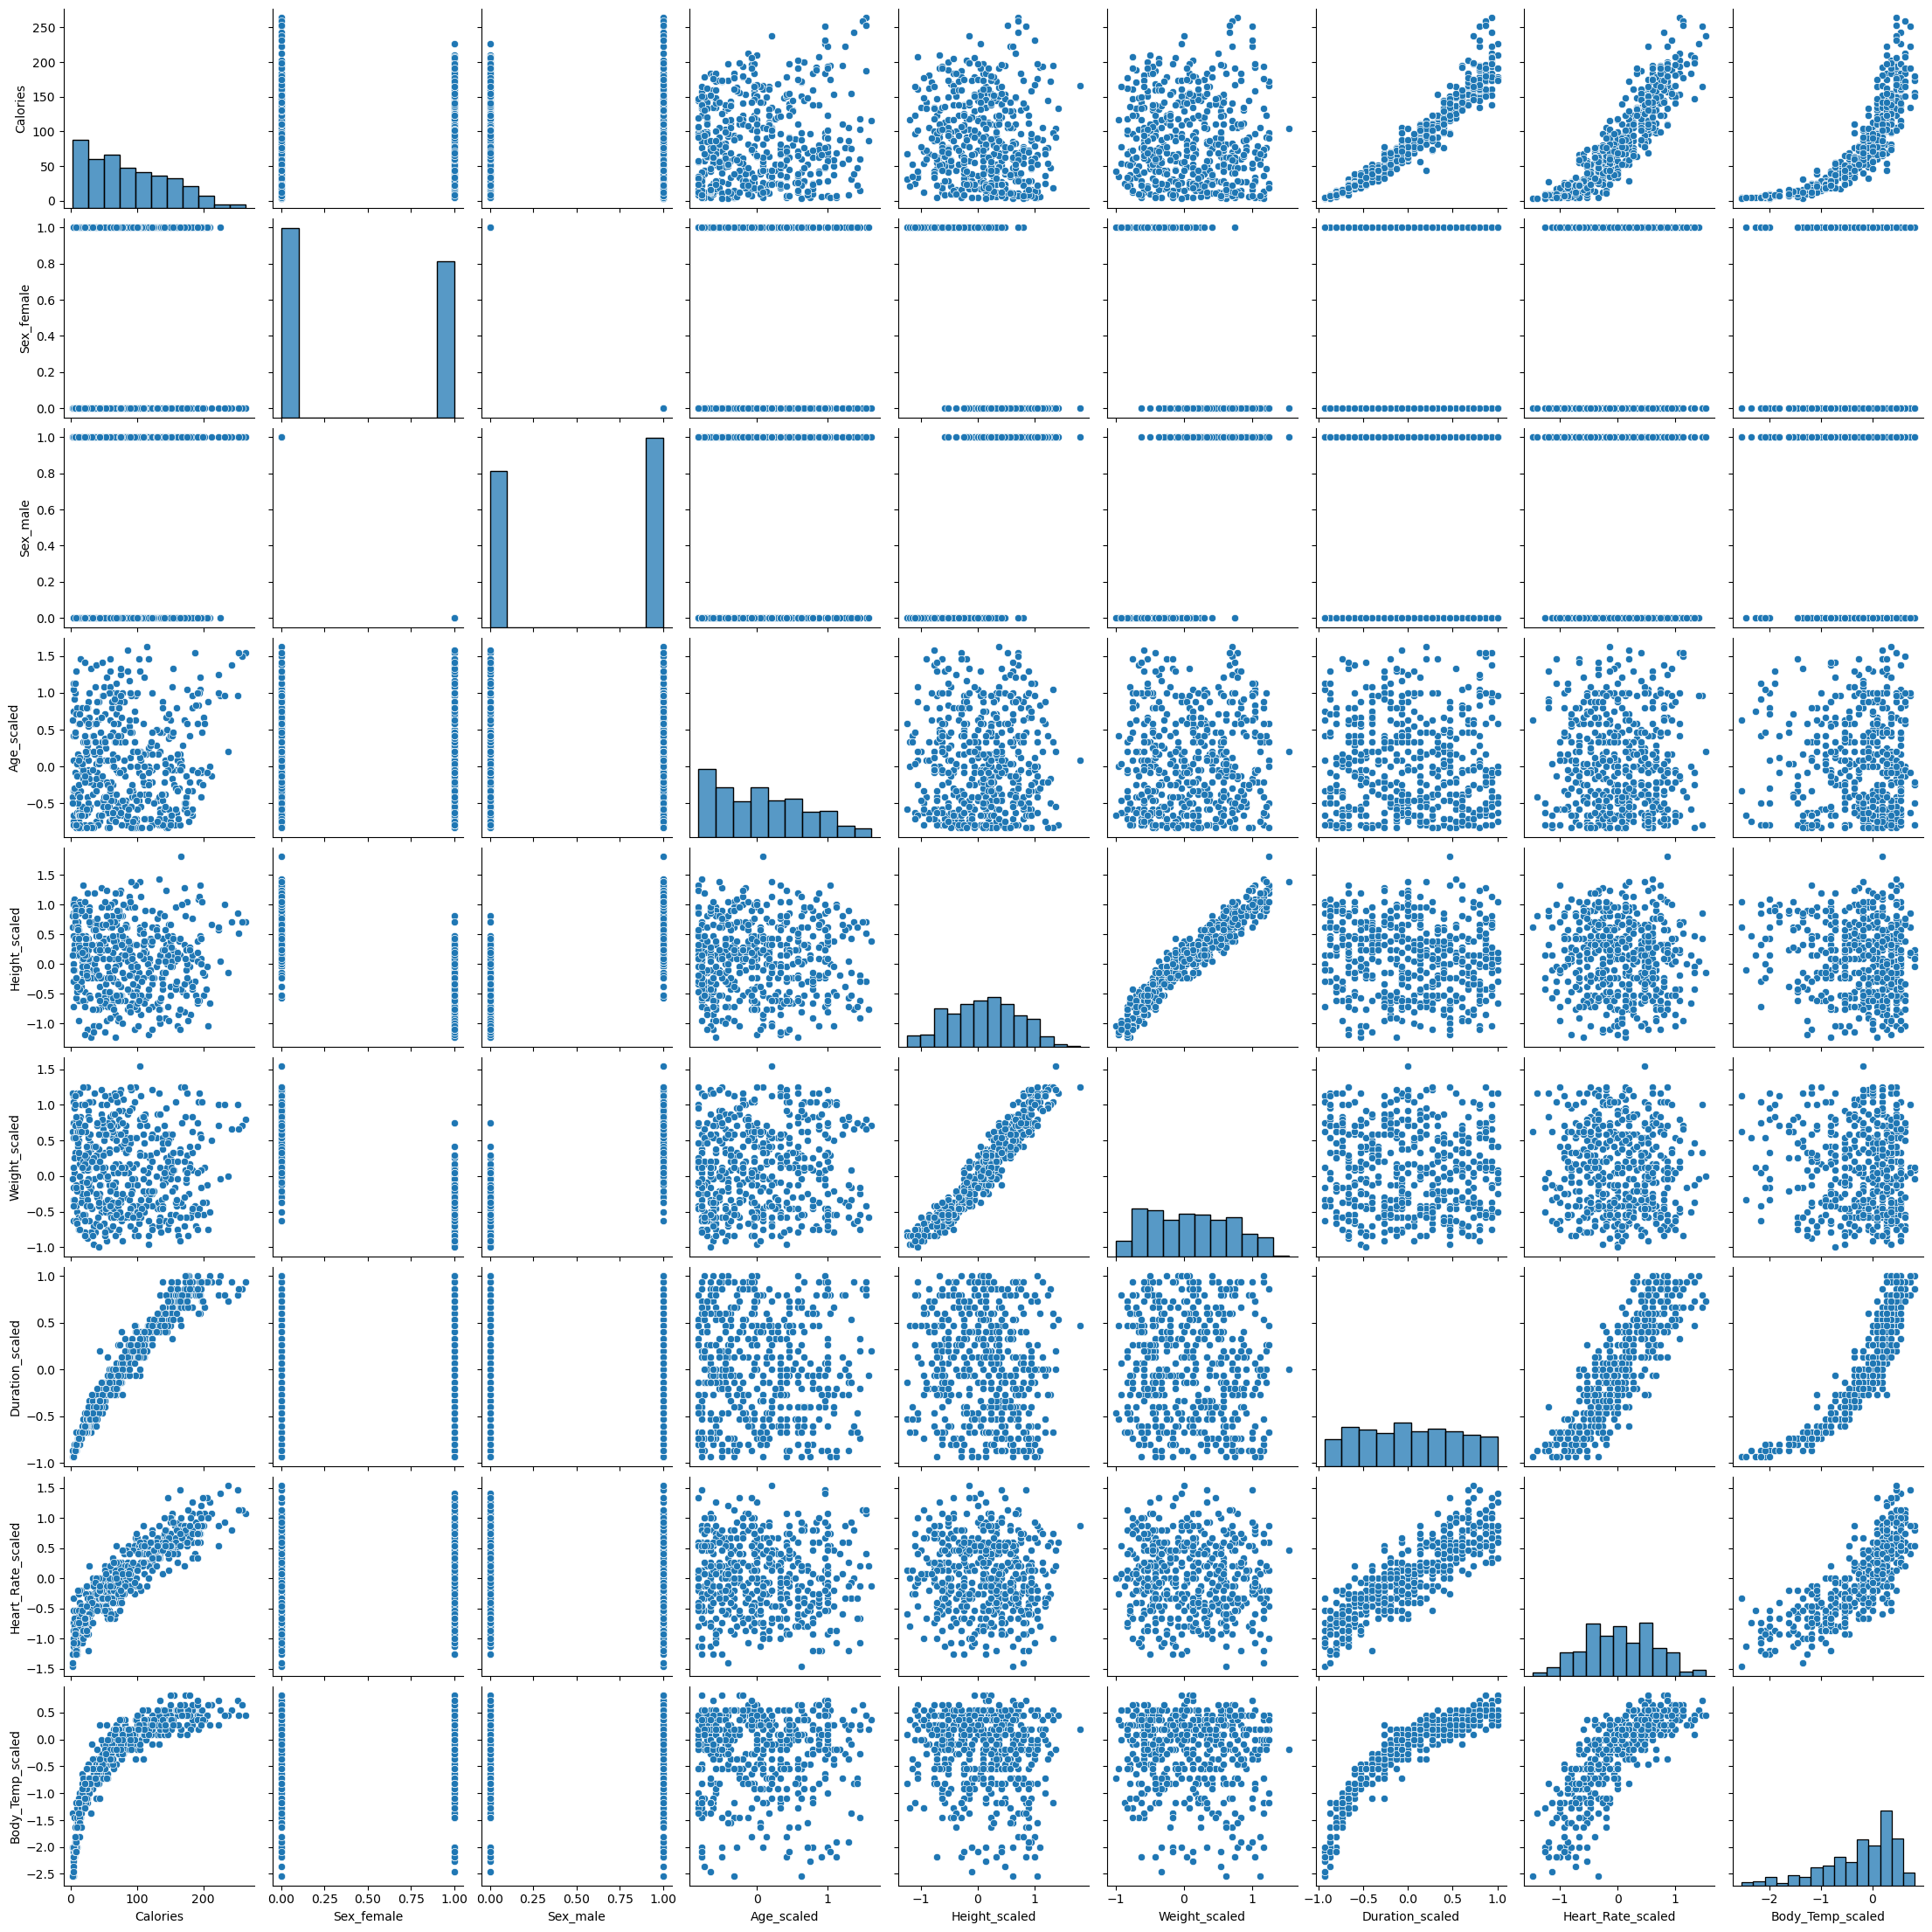

In [12]:
sampled_df = df.sample(n=500, random_state=42) 
sns.pairplot(sampled_df)

In [13]:
corr = df.corr()
corr

,Calories,Sex_female,Sex_male,Age_scaled,Height_scaled,Weight_scaled,Duration_scaled,Heart_Rate_scaled,Body_Temp_scaled
Calories,1.000000,-0.012011,0.012011,0.145683,-0.004026,0.015863,0.959908,0.908748,0.828671
Sex_female,-0.012011,1.000000,-1.000000,-0.009689,-0.755906,-0.818250,0.009594,-0.009122,0.015933
Sex_male,0.012011,-1.000000,1.000000,0.009689,0.755906,0.818250,-0.009594,0.009122,-0.015933
Age_scaled,0.145683,-0.009689,0.009689,1.000000,0.011975,0.073690,0.015656,0.017037,0.030275
Height_scaled,-0.004026,-0.755906,0.755906,0.011975,1.000000,0.957967,-0.029936,-0.013234,-0.034641
Weight_scaled,0.015863,-0.818250,0.818250,0.073690,0.957967,1.000000,-0.020845,-0.002384,-0.023717
Duration_scaled,0.959908,0.009594,-0.009594,0.015656,-0.029936,-0.020845,1.000000,0.875327,0.903066
Heart_Rate_scaled,0.908748,-0.009122,0.009122,0.017037,-0.013234,-0.002384,0.875327,1.000000,0.795972
Body_Temp_scaled,0.828671,0.015933,-0.015933,0.030275,-0.034641,-0.023717,0.903066,0.795972,1.000000


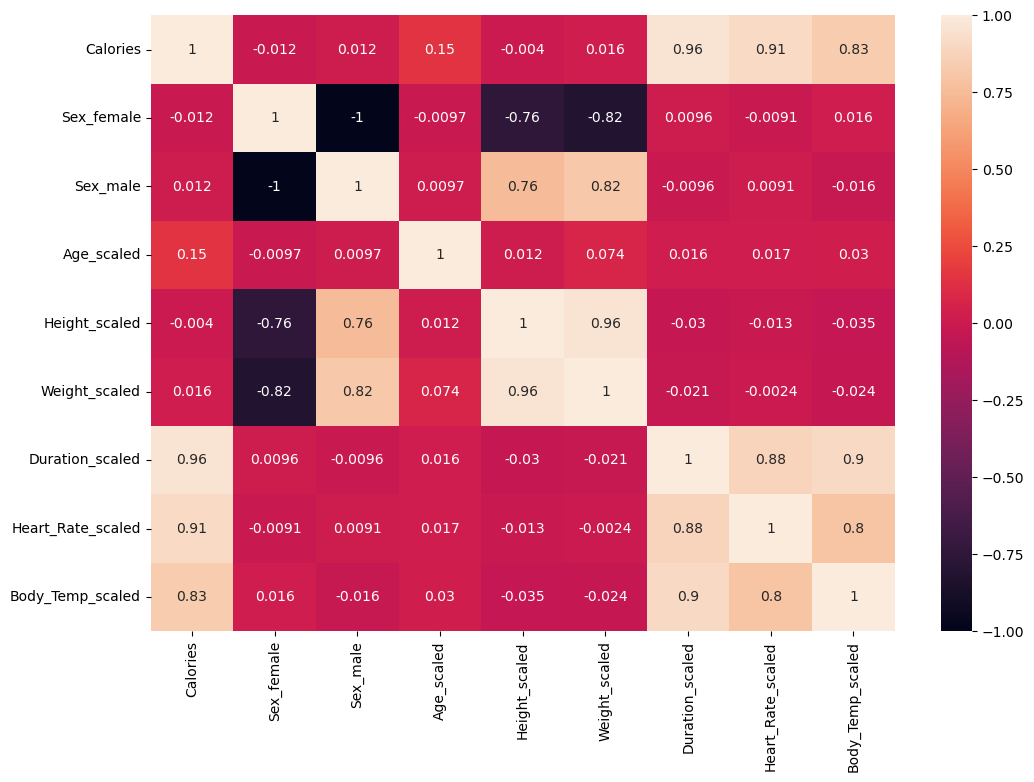

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot = True)
plt.show()

In [15]:
X = df.drop(columns=['Calories'])
y = df['Calories']

In [16]:
X.head()

,Sex_female,Sex_male,Age_scaled,Height_scaled,Weight_scaled,Duration_scaled,Heart_Rate_scaled,Body_Temp_scaled
0,False,True,-0.166667,0.714286,0.333333,0.733333,0.400000,0.636364
1,True,False,1.000000,-0.523810,-0.583333,-0.466667,-0.666667,-0.545455
2,True,False,0.458333,-0.619048,-0.416667,-0.533333,-0.733333,-0.454545
3,False,True,-0.833333,0.857143,0.666667,0.666667,0.666667,0.363636
4,True,False,-0.083333,-0.380952,-0.541667,0.666667,0.466667,0.272727


In [17]:
y

0         150.0
1          34.0
2          29.0
3         140.0
4         146.0
          ...  
749995    230.0
749996     96.0
749997    221.0
749998    109.0
749999    103.0
Name: Calories, Length: 750000, dtype: float64

Splitting the data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model-stacking

In [19]:
#Random Forest
rf = RandomForestRegressor(
    n_estimators=200, max_depth=20,
    min_samples_split=4, min_samples_leaf=2,
    max_features='sqrt', random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

#LightGBM
lgbm = LGBMRegressor(
    n_estimators=200, max_depth=5,
    learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, random_state=42, n_jobs=-1
)
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)

#CatBoost
cat = CatBoostRegressor(
    iterations=500, depth=6, learning_rate=0.05,
    loss_function='RMSE', verbose=0, random_seed=42
)
cat.fit(X_train, y_train)
cat_preds = cat.predict(X_test)

base_models = [
    ('rf', RandomForestRegressor(n_estimators=200,
                                  max_depth=20,
                                  min_samples_split=4,
                                  min_samples_leaf=2,
                                  max_features='sqrt',
                                  random_state=42,
                                  n_jobs=-1
                                )),
    ('lgbm', LGBMRegressor(n_estimators=200,
                      max_depth=10,
                      learning_rate=0.08,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      random_state=42,
                      n_jobs=-1
                    )),
    ('cat', CatBoostRegressor(iterations=500,
                                   depth=6,
                                   learning_rate=0.05,
                                   loss_function='RMSE',
                                   verbose=0,
                                   random_seed=42
                                  ))
]

meta_model = XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
    )

stack_clf = StackingRegressor(estimators=base_models,
                               final_estimator=meta_model,
                               passthrough=True
                              )
stack_clf.fit(X_train, y_train)

stacked_preds = stack_clf.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Model Accuracy

In [20]:
print(f"Random Forest:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, rf_preds):.4f}")
print(f"R² Score: {r2_score(y_test, rf_preds):.4f}")

print(f"\nLightGBM")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lgbm_preds)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, lgbm_preds):.4f}")
print(f"R² Score: {r2_score(y_test, lgbm_preds):.4f}")

print(f"\nCatBoost")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, cat_preds)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, cat_preds):.4f}")
print(f"R² Score: {r2_score(y_test, cat_preds):.4f}")

rmse = np.sqrt(mean_squared_error(y_test, stacked_preds))
mae = mean_absolute_error(y_test, stacked_preds)
r2 = r2_score(y_test, stacked_preds)
print("\nFinal stacked model: ")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Random Forest:
RMSE: 3.8179
MAE: 2.2803
R² Score: 0.9962

LightGBM
RMSE: 3.8676
MAE: 2.4695
R² Score: 0.9961

CatBoost
RMSE: 3.6096
MAE: 2.1881
R² Score: 0.9966

Final stacked model: 
RMSE: 3.5823
MAE: 2.1463
R² Score: 0.9967


Test data preprocessing

In [21]:
test = pd.get_dummies(test, columns=['Sex'], drop_first=False)
from sklearn.preprocessing import RobustScaler

def scale_columns(df, columns_to_scale):
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(df[columns_to_scale])

    for i, col in enumerate(columns_to_scale):
        df[col + '_scaled'] = scaled_features[:, i]

    return df

cols =['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
test = scale_columns(test, cols)

cols += ['id']
test.drop(cols, axis=1, inplace=True)

In [22]:
test

,Sex_female,Sex_male,Age_scaled,Height_scaled,Weight_scaled,Duration_scaled,Heart_Rate_scaled,Body_Temp_scaled
0,False,True,0.208333,0.142857,0.291667,-0.533333,-0.533333,-0.5
1,False,True,-0.583333,1.238095,0.958333,0.333333,0.400000,0.2
2,True,False,-0.458333,0.666667,0.458333,0.066667,0.466667,0.1
3,True,False,-0.041667,-0.095238,-0.041667,0.333333,0.800000,0.3
4,True,False,-0.416667,-0.047619,-0.291667,0.066667,-0.066667,0.2
...,...,...,...,...,...,...,...,...
249995,True,False,0.666667,-0.714286,-0.500000,-0.600000,-0.666667,-0.9
249996,False,True,-0.333333,1.333333,1.125000,-0.800000,-0.733333,-1.9
249997,True,False,-0.375000,-0.476190,-0.416667,-0.066667,0.200000,-0.2
249998,True,False,0.916667,-0.761905,-0.541667,0.666667,0.733333,0.4


Submission file 

In [ ]:
final_test_preds = stack_clf.predict(test)

submission = pd.DataFrame({
    'id': pd.read_csv("data/test.csv")['id'],
    'Calories': final_test_preds
})
submission.to_csv("data/submission.csv", index=False)
print("Done")

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'